# Library Import

In [1]:
#to display all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

#import scipy
import struct

from pathlib import Path
from sympy import divisors

from astropy.stats import jackknife_resampling
from astropy.stats import jackknife_stats

from scipy.stats import bootstrap

from scipy.optimize import curve_fit #for the fit

# Input Reading

In [3]:
#dirName = '../mesons-master/build/dat/'
#name = 'odd_prova26.odd_df2_4fop'
dirName = '../../data_from_scp/'
#name = 'tm_mesons_run3.mesons'
name = 'tm_mesons_run6.mesons'
datName = name + '.dat'

fileName = dirName + datName

In [4]:
plot_base_dir = 'plots/'
plot_dir = 'plot_'+name.split('.')[0]
Path(plot_base_dir+plot_dir).mkdir(parents=True, exist_ok=True)

In [5]:
verbose=True #True to print more output

step = 1 #steps at which configurations are read

early_stop = 0 #number of configurations (counting from the end) not read

In [6]:
#the correlators array will be stored in a dict having as keys the configurations
conf_dict = {}

#list with configurations number
conf_num_list = []

##### reading data from binary dat file #####
with open(fileName, mode='rb') as file: # b is important -> binary
    fileContent = file.read()

    #header is made up of 4 integers, 4x4=16byte
    header_size= 4*4

    #first 16 byte are four 4-byte integers
    ncorr, nnoise, tvals, noise_type = struct.unpack("iiii", fileContent[:header_size])

    #initialization of correlators' variables
    k1=['']*ncorr
    k2=['']*ncorr
    
    mu1=['']*ncorr
    mu2=['']*ncorr

    type1=['']*ncorr
    type2=['']*ncorr
    
    x0=['']*ncorr
    isreal=['']*ncorr

    
    #each correlator has an header of size given by 4x8 + 4x4 = 48byte
    corr_header_size = 4*8 + 4*4
    
    #then there are ncorr block, 8x8 + 4x4 (8 double and 4 int) with the following structure 
    for i in range(ncorr):
         k1[i], k2[i], mu1[i], mu2[i], type1[i], type2[i], x0[i], isreal[i] = struct.unpack("ddddiiii",fileContent[header_size+corr_header_size*i:header_size+corr_header_size*(i+1)])



    #initialization of correlators array
    corr = np.empty(shape=(ncorr,tvals,nnoise),dtype=complex) #correlators
    

    #configuration start right after the header
    first_conf = header_size+corr_header_size*ncorr
    
    #we compute the lenght of the data block for each configuration
    #          sizeof(int) (=confNumber)           ncorr * nnoise * tvals * 2 (re+im) * 8 (sizeof(double))
    conf_len = 4                                 +  nnoise * tvals * (2*ncorr - np.sum(isreal))         * 8         
    #the term with isreal is there because for real correlators only the real part gets stored

    #starting right after the header we read each configuration block
    for start_conf in range(first_conf, len(fileContent)-conf_len*early_stop, conf_len*step):
    #for start_conf in range(first_conf, len(fileContent)-conf_len, conf_len):

        #breaks loop if the file does not contain the whole correlator for the given configuration
        if start_conf+conf_len > len(fileContent) :
            break

        #reading of the configuration number
        conf_number = struct.unpack("i",fileContent[start_conf:start_conf+4])[0]
        if verbose==True:
            print(f"Reading: Gauge Conf = {conf_number}\n")

        #store of conf num
        if conf_number not in conf_num_list:
            conf_num_list.append(conf_number)

        #initialize to 0 the array storing the correlators
        corr.fill(complex(0,0))

        #initialize start reading
        start_reading = start_conf + 4

        #loop over the correlators (ncorr blocks of...)
        for ic in range(ncorr):
            
            #reading of 2 point functions
            for t in range(tvals):
                
                for inoise in range(nnoise):

                    if isreal[ic]==0:
                        #read re and im
                        re,im = struct.unpack("dd",fileContent[start_reading:start_reading+16])
                        #store them
                        corr[ic][t][inoise] = complex(re,im)
                        #update start reading
                        start_reading = start_reading+16

                    if isreal[ic]==1:
                        #read re
                        re = struct.unpack("d",fileContent[start_reading:start_reading+8])[0]
                        #store it
                        corr[ic][t][inoise] = complex(re,0.0)
                        #update start reading
                        start_reading = start_reading+8
                        
                    

        #store of correlators associated to the given configuration
        conf_dict[str(conf_number)] = corr.copy()

Reading: Gauge Conf = 1

Reading: Gauge Conf = 2

Reading: Gauge Conf = 3

Reading: Gauge Conf = 4

Reading: Gauge Conf = 5

Reading: Gauge Conf = 6

Reading: Gauge Conf = 7

Reading: Gauge Conf = 8

Reading: Gauge Conf = 9

Reading: Gauge Conf = 10

Reading: Gauge Conf = 11

Reading: Gauge Conf = 12

Reading: Gauge Conf = 13

Reading: Gauge Conf = 14

Reading: Gauge Conf = 15

Reading: Gauge Conf = 16

Reading: Gauge Conf = 17

Reading: Gauge Conf = 18

Reading: Gauge Conf = 19

Reading: Gauge Conf = 20

Reading: Gauge Conf = 21

Reading: Gauge Conf = 22

Reading: Gauge Conf = 23

Reading: Gauge Conf = 24

Reading: Gauge Conf = 25

Reading: Gauge Conf = 26

Reading: Gauge Conf = 27

Reading: Gauge Conf = 28

Reading: Gauge Conf = 29

Reading: Gauge Conf = 30

Reading: Gauge Conf = 31

Reading: Gauge Conf = 32

Reading: Gauge Conf = 33

Reading: Gauge Conf = 34

Reading: Gauge Conf = 35

Reading: Gauge Conf = 36

Reading: Gauge Conf = 37

Reading: Gauge Conf = 38

Reading: Gauge Conf =

In [7]:
#check on correct lenght calculations
(len(fileContent)-header_size-corr_header_size*ncorr)/conf_len

100.0

In [8]:
#construction of array with names and numbers of configurations
conf_names = list(conf_dict.keys())
conf_list = [int(conf) for conf in conf_names ]
nconf = len(conf_list)
nconf

100

In [9]:
#creation of a numpy array with all the correlators
correlators = np.empty(shape=(nconf,ncorr,tvals,nnoise),dtype=complex)
for iconf,nameconf in enumerate(conf_names):
    correlators[iconf] = conf_dict[nameconf]

In [10]:
if verbose:
    print("(nconf, ncorrelators, tvals, nnoise)")
    print(np.shape(correlators))

(nconf, ncorrelators, tvals, nnoise)
(100, 4, 32, 100)


In [11]:
if verbose:
    for icorr in range(ncorr):
        print(f"k1  = {k1[icorr]}\n")
        print(f"k2  = {k2[icorr]}\n")
        print(f"mu1 = {mu1[icorr]}\n")
        print(f"mu2 = {mu2[icorr]}\n")
        print(f"G1  = {type1[icorr]}\n")
        print(f"G2  = {type2[icorr]}\n")
        print(f"x0  = {x0[icorr]}\n")
        print(f"isr = {isreal[icorr]}\n\n")

k1  = 0.135217

k2  = 0.135217

mu1 = 0.0454

mu2 = 0.0454

G1  = 5

G2  = 5

x0  = 1

isr = 1


k1  = 0.135217

k2  = 0.135217

mu1 = 0.0454

mu2 = -0.0454

G1  = 5

G2  = 5

x0  = 1

isr = 0


k1  = 0.135217

k2  = 0.135217

mu1 = 0.0454

mu2 = 0.0454

G1  = 5

G2  = 5

x0  = 30

isr = 1


k1  = 0.135217

k2  = 0.135217

mu1 = 0.0454

mu2 = -0.0454

G1  = 5

G2  = 5

x0  = 30

isr = 0




In [12]:
corr_1 = correlators[:,0,:,:]
corrTilda_1 = correlators[:,1,:,:]
corr_T = correlators[:,2,:,:]
corrTilda_T = correlators[:,3,:,:]

if verbose:
    print("(nconf, tvals, nnoise)")
    print(np.shape(corr_1))
    print(np.shape(corrTilda_1))
    print(np.shape(corrTilda_1))
    #print(np.shape(corrTilda_T))

(nconf, tvals, nnoise)
(100, 32, 100)
(100, 32, 100)
(100, 32, 100)


# Average over Noise

In [13]:
corr_1_navg = corr_1.mean(axis=-1)
corrTilda_1_navg = corrTilda_1.mean(axis=-1)
corr_T_navg = corr_T.mean(axis=-1)
corrTilda_T_navg = corrTilda_T.mean(axis=-1)

if verbose:
    print("(nconf, tvals)")
    print(np.shape(corr_1_navg))
    print(np.shape(corrTilda_1_navg))
    print(np.shape(corr_T_navg))
    print(np.shape(corrTilda_T_navg))

(nconf, tvals)
(100, 32)
(100, 32)
(100, 32)
(100, 32)


In [14]:
#the correlator with a twisted term is not real
np.mean(np.abs((corrTilda_1_navg.imag/corrTilda_1_navg.real)[:,1:-1]))

/tmp/ipykernel_61351/2706896938.py:2: RuntimeWarning: invalid value encountered in divide
  np.mean(np.abs((corrTilda_1_navg.imag/corrTilda_1_navg.real)[:,1:-1]))


0.009810234418873989

# Preliminary Plots and Analysys

Text(0.5, 1.0, 'cut = 1    -    corr_1')

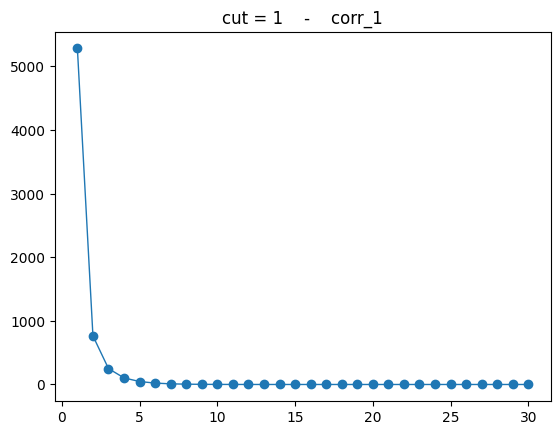

In [15]:
times = np.arange(tvals)

cut = 1
plt.title(f"cut = {cut}    -    corr_1")
#plt.yscale('log')
plt.plot(times[cut:-cut],np.mean(corr_1_navg,axis=0).real[cut:-cut], '-o',linewidth = 1)

Text(0.5, 1.0, 'cut = 1    -    corr_T')

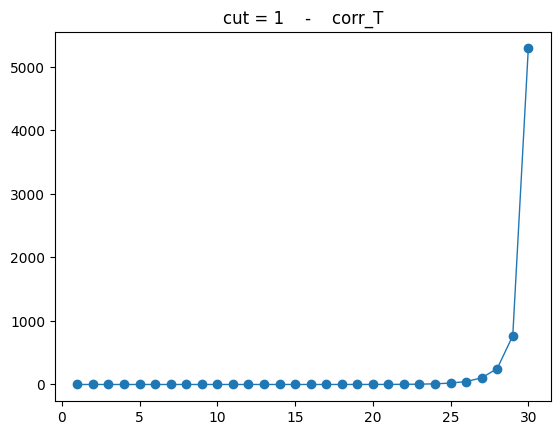

In [16]:
times = np.arange(tvals)

cut = 1
plt.title(f"cut = {cut}    -    corr_T")
#plt.yscale('log')
plt.plot(times[cut:-cut],np.mean(corr_T_navg,axis=0).real[cut:-cut], '-o',linewidth = 1)

Text(0.5, 1.0, 'cut = 1    -    corrTilda_1')

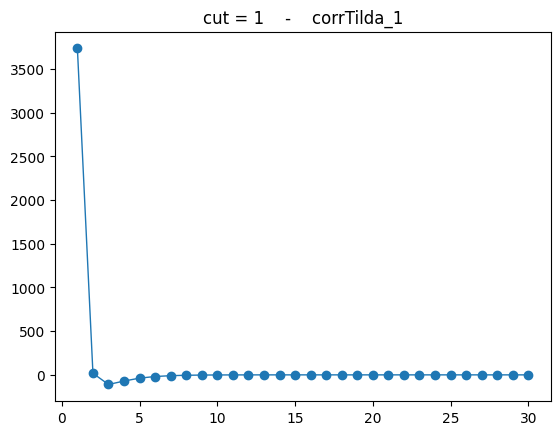

In [17]:
times = np.arange(tvals)

cut = 1
plt.title(f"cut = {cut}    -    corrTilda_1")
#plt.yscale('log')
plt.plot(times[cut:-cut],np.mean(corrTilda_1_navg,axis=0).real[cut:-cut], '-o',linewidth = 1)
#plt.plot(times[cut:-cut],np.mean(corrTilda_1_navg,axis=0).imag[cut:-cut], '-o',linewidth = 1)

Text(0.5, 1.0, 'cut = 1    -    corrTilda_T')

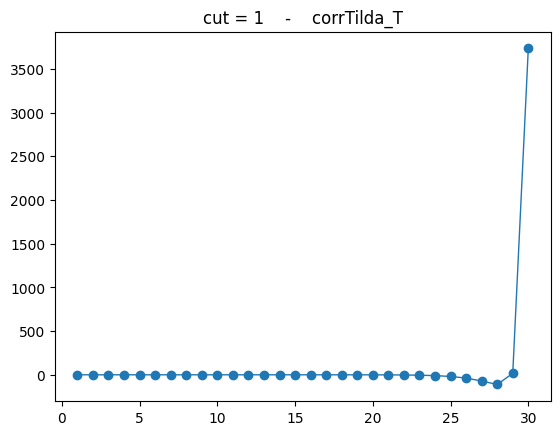

In [18]:

times = np.arange(tvals)

cut = 1
plt.title(f"cut = {cut}    -    corrTilda_T")
#plt.yscale('log')
plt.plot(times[cut:-cut],np.mean(corrTilda_T_navg,axis=0).real[cut:-cut], '-o',linewidth = 1)
#plt.plot(times[cut:-cut],np.mean(corrTilda_T_navg,axis=0).imag[cut:-cut], '-o',linewidth = 1)

# Mass extraction

## mass from log

### jackknife first

In [53]:
test_statistic = np.mean

corr_1_navg_jack = np.empty(shape=(tvals),dtype=float)
corr_1_navg_jack_std = np.empty(shape=(tvals),dtype=float)
corr_T_navg_jack = np.empty(shape=(tvals),dtype=float)
corr_T_navg_jack_std = np.empty(shape=(tvals),dtype=float)

corrTilda_1_navg_jack = np.empty(shape=(tvals),dtype=float)
corrTilda_1_navg_jack_std = np.empty(shape=(tvals),dtype=float)
corrTilda_T_navg_jack = np.empty(shape=(tvals),dtype=float)
corrTilda_T_navg_jack_std = np.empty(shape=(tvals),dtype=float)

for t in range(tvals):

    #for corr
    
    data = corr_1_navg[:,t].real

            
    estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)

    corr_1_navg_jack[t] = estimate
    corr_1_navg_jack_std[t] = stderr

    
    data = corr_T_navg[:,t].real

            
    estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)

    corr_T_navg_jack[t] = estimate
    corr_T_navg_jack_std[t] = stderr
    
    #for corrTilda    

    data = corrTilda_1_navg[:,t].real

            
    estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)

    corrTilda_1_navg_jack[t] = estimate
    corrTilda_1_navg_jack_std[t] = stderr

    
    data = corrTilda_T_navg[:,t].real

            
    estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)

    corrTilda_T_navg_jack[t] = estimate
    corrTilda_T_navg_jack_std[t] = stderr

In [54]:
fp = 0.5 * (corr_1_navg_jack[::-1] + corr_T_navg_jack[:])

fp_std = 0.5 * np.sqrt(corr_1_navg_jack[::-1]**2 + corr_T_navg_jack[:]**2 )


fpTilda = 0.5 * (corrTilda_1_navg_jack[::-1] + corrTilda_T_navg_jack[:])

fpTilda_std = 0.5 * np.sqrt(corrTilda_1_navg_jack[::-1]**2 + corrTilda_T_navg_jack[:]**2 )

Text(0.5, 1.0, 'cut = 3')

<ErrorbarContainer object of 3 artists>

<Figure size 640x480 with 0 Axes>

<ErrorbarContainer object of 3 artists>

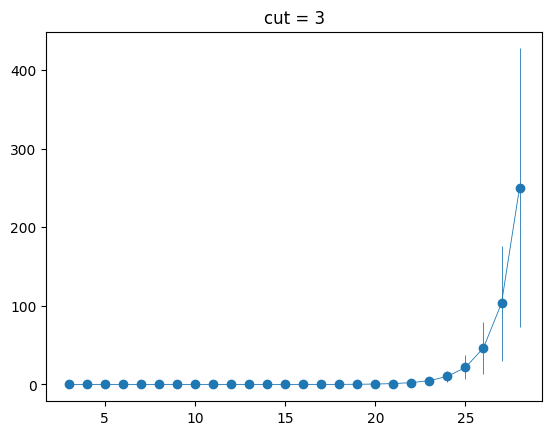

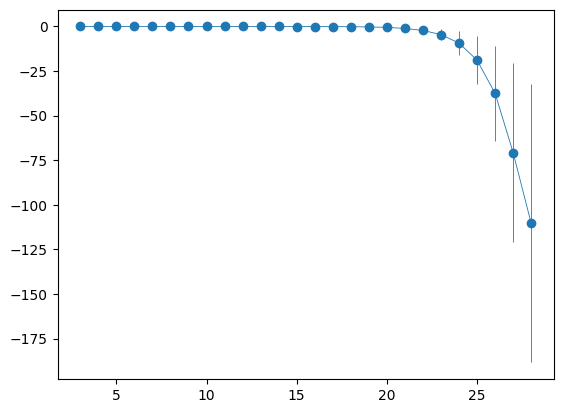

In [55]:
times = np.arange(tvals)

cut=3
plt.title(f"cut = {cut}")
plt.errorbar(times[cut:-cut],fp[cut:-cut],yerr=fp_std[cut:-cut],marker='o',linewidth=0.6)
plt.figure()
plt.errorbar(times[cut:-cut],fpTilda[cut:-cut],yerr=fpTilda_std[cut:-cut],marker='o',linewidth=0.6)

In [56]:
eff_mass = np.log( fp[0:-1]/fp[1:]  )

eff_mass_tilda = np.log( fpTilda[-2::-1]/fpTilda[:0:-1]  )

/tmp/ipykernel_61351/1564018484.py:1: RuntimeWarning: divide by zero encountered in divide
  eff_mass = np.log( fp[0:-1]/fp[1:]  )
/tmp/ipykernel_61351/1564018484.py:1: RuntimeWarning: divide by zero encountered in log
  eff_mass = np.log( fp[0:-1]/fp[1:]  )
/tmp/ipykernel_61351/1564018484.py:3: RuntimeWarning: divide by zero encountered in divide
  eff_mass_tilda = np.log( fpTilda[-2::-1]/fpTilda[:0:-1]  )
/tmp/ipykernel_61351/1564018484.py:3: RuntimeWarning: divide by zero encountered in log
  eff_mass_tilda = np.log( fpTilda[-2::-1]/fpTilda[:0:-1]  )
/tmp/ipykernel_61351/1564018484.py:3: RuntimeWarning: invalid value encountered in log
  eff_mass_tilda = np.log( fpTilda[-2::-1]/fpTilda[:0:-1]  )


<Figure size 640x480 with 0 Axes>

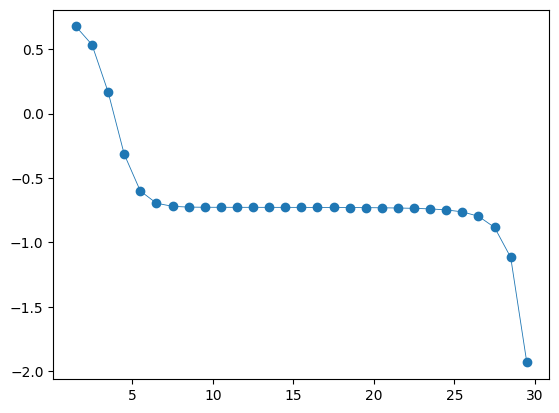

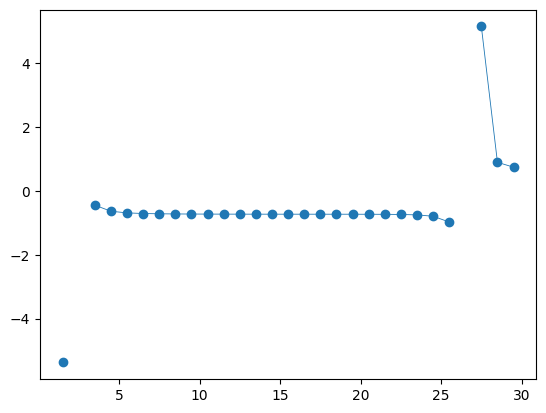

In [57]:
times = np.arange(0,tvals)
eff_mass_times = times[:-1]+0.5

plt.plot(eff_mass_times,eff_mass,'-o',linewidth=0.6)

plt.figure()
plt.plot(eff_mass_times,eff_mass_tilda,'-o',linewidth=0.6)

In [58]:
cut=7
-np.mean(eff_mass[cut:-cut])

-np.mean(eff_mass_tilda[cut:-cut])

0.7294643375698026

0.7274208889912357

### jacknife last

In [59]:
fp = 0.5 * (corr_1_navg[:,::-1] + corr_T_navg[:,:])

eff_mass = np.log( fp[:,0:-1].real/fp[:,1:].real  )


fpTilda = 0.5 * (corrTilda_1_navg[:,::-1] + corrTilda_T_navg[:,:])

eff_mass_tilda = np.log( fpTilda[:,-2::-1].real/fpTilda[:,:0:-1].real  )

/tmp/ipykernel_61351/2583113244.py:3: RuntimeWarning: divide by zero encountered in divide
  eff_mass = np.log( fp[:,0:-1].real/fp[:,1:].real  )
/tmp/ipykernel_61351/2583113244.py:3: RuntimeWarning: divide by zero encountered in log
  eff_mass = np.log( fp[:,0:-1].real/fp[:,1:].real  )
/tmp/ipykernel_61351/2583113244.py:8: RuntimeWarning: divide by zero encountered in divide
  eff_mass_tilda = np.log( fpTilda[:,-2::-1].real/fpTilda[:,:0:-1].real  )
/tmp/ipykernel_61351/2583113244.py:8: RuntimeWarning: divide by zero encountered in log
  eff_mass_tilda = np.log( fpTilda[:,-2::-1].real/fpTilda[:,:0:-1].real  )
/tmp/ipykernel_61351/2583113244.py:8: RuntimeWarning: invalid value encountered in log
  eff_mass_tilda = np.log( fpTilda[:,-2::-1].real/fpTilda[:,:0:-1].real  )


In [60]:
test_statistic = np.mean

eff_mass_jack = np.empty(shape=(tvals-1),dtype=float)
eff_mass_jack_std = np.empty(shape=(tvals-1),dtype=float)

eff_mass_tilda_jack = np.empty(shape=(tvals-1),dtype=float)
eff_mass_tilda_jack_std = np.empty(shape=(tvals-1),dtype=float)

for t in range(tvals-1):
    
    data = eff_mass[:,t]

            
    estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)

    eff_mass_jack[t] = estimate
    eff_mass_jack_std[t] = stderr


    data = eff_mass_tilda[:,t]

            
    estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)

    eff_mass_tilda_jack[t] = estimate
    eff_mass_tilda_jack_std[t] = stderr

/home/tag-e/università/Magistrale/tesi/codice/myCode/python_analysis/my_env/lib/python3.10/site-packages/astropy/stats/jackknife.py:163: RuntimeWarning: invalid value encountered in scalar subtract
  bias = (n - 1) * (mean_jack_stat - stat_data)
/home/tag-e/università/Magistrale/tesi/codice/myCode/python_analysis/my_env/lib/python3.10/site-packages/astropy/stats/jackknife.py:168: RuntimeWarning: invalid value encountered in subtract
  * np.mean((jack_stat - mean_jack_stat) * (jack_stat - mean_jack_stat), axis=0)


Text(0.5, 1.0, 'cut = 7')

<ErrorbarContainer object of 3 artists>

<Figure size 640x480 with 0 Axes>

<ErrorbarContainer object of 3 artists>

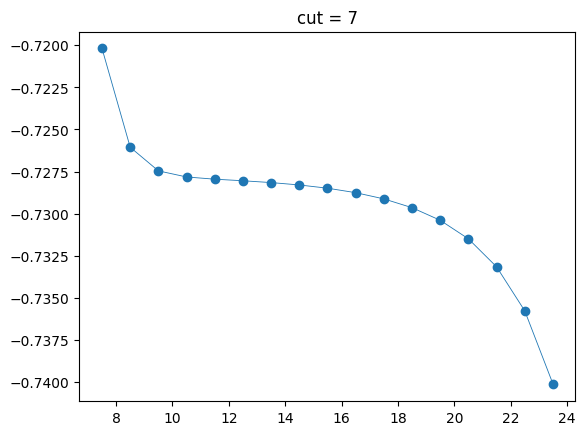

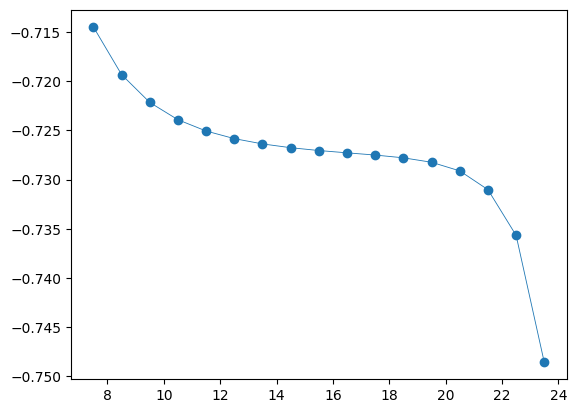

In [61]:
times = np.arange(0,tvals)
eff_mass_times = times[:-1]+0.5

cut = 7

plt.title(f"cut = {cut}")

plt.errorbar(eff_mass_times[cut:-cut],eff_mass_jack[cut:-cut],yerr=eff_mass_jack_std[cut:-cut],marker='o',linewidth=0.6)

plt.figure()
plt.errorbar(eff_mass_times[cut:-cut],eff_mass_tilda_jack[cut:-cut],yerr=eff_mass_tilda_jack_std[cut:-cut],marker='o',linewidth=0.6)

In [63]:
mass_aver = -np.mean(eff_mass_jack[cut:-cut])
mass_aver_std = np.sqrt(np.mean(eff_mass_jack_std[cut:-cut]**2))

mass_aver
mass_aver_std


mass_aver_tilda = -np.mean(eff_mass_tilda_jack[cut:-cut])
mass_aver_tilda_std = np.sqrt(np.mean(eff_mass_tilda_jack_std[cut:-cut]**2))

mass_aver_tilda
mass_aver_tilda_std

0.7294662292508642

1.1864657734702986e-05

0.7274187051556011

1.3357538759196985e-05

## mass from sinh fit

In [64]:
test_statistic = np.mean

corr_1_navg_jack = np.empty(shape=(tvals),dtype=float)
corr_1_navg_jack_std = np.empty(shape=(tvals),dtype=float)
corr_T_navg_jack = np.empty(shape=(tvals),dtype=float)
corr_T_navg_jack_std = np.empty(shape=(tvals),dtype=float)

corrTilda_1_navg_jack = np.empty(shape=(tvals),dtype=float)
corrTilda_1_navg_jack_std = np.empty(shape=(tvals),dtype=float)
corrTilda_T_navg_jack = np.empty(shape=(tvals),dtype=float)
corrTilda_T_navg_jack_std = np.empty(shape=(tvals),dtype=float)

for t in range(tvals):

    #for corr
    
    data = corr_1_navg[:,t].real

            
    estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)

    corr_1_navg_jack[t] = estimate
    corr_1_navg_jack_std[t] = stderr

    
    data = corr_T_navg[:,t].real

            
    estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)

    corr_T_navg_jack[t] = estimate
    corr_T_navg_jack_std[t] = stderr


    #for corrTilda
    
    data = corrTilda_1_navg[:,t].real

            
    estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)

    corrTilda_1_navg_jack[t] = estimate
    corrTilda_1_navg_jack_std[t] = stderr

    
    data = corrTilda_T_navg[:,t].real

            
    estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)

    corrTilda_T_navg_jack[t] = estimate
    corrTilda_T_navg_jack_std[t] = stderr

In [65]:
fp = 0.5 * (corr_1_navg_jack[::-1] + corr_T_navg_jack[:])

fp_std = 0.5 * np.sqrt(corr_1_navg_jack[::-1]**2 + corr_T_navg_jack[:]**2 )


fpTilda = 0.5 * (corrTilda_1_navg_jack[::-1] + corrTilda_T_navg_jack[:])

fpTilda_std = 0.5 * np.sqrt(corrTilda_1_navg_jack[::-1]**2 + corrTilda_T_navg_jack[:]**2 )

In [66]:
def chi2(result,data,data_std):
    return np.sum( ((result-data)/data_std)**2 )

In [67]:
guess_mass = 0.42
guess_amp =  fp[-4]

def fit_sinh(t,amp,mass):
    return amp*np.sinh(mass*t)

guess_amp_tilda =  fpTilda[4]

In [68]:
#cut  = 12
cut = 5

fit_times = times[cut:-cut]

fit_data = fp[cut:-cut]

guess = [guess_amp,guess_mass]


fit_data_tilda = fpTilda[cut:-cut]

guess_tilda = [guess_amp_tilda,guess_mass]

In [69]:
popt,pcov = curve_fit(fit_sinh, fit_times, fit_data, p0=guess)
perr = np.sqrt(np.diag(pcov))
fit_result = fit_sinh(fit_times,*popt)

print("Result corr:")
print(f"amp:  {popt[0]} +- {perr[0]}")
print(f"mass: {popt[1]} +- {perr[1]}\n")


popt,pcov = curve_fit(fit_sinh, fit_times, fit_data_tilda, p0=guess_tilda)
perr = np.sqrt(np.diag(pcov))
fit_result_tilda = fit_sinh(fit_times,*popt)

print("Result corrTilda:")
print(f"amp:  {popt[0]} +- {perr[0]}")
print(f"mass: {popt[1]} +- {perr[1]}\n")

Result corr:
amp:  2.707896656875908e-07 +- 1.022369507383177e-08
mass: 0.755959171852763 +- 0.0014676903253203978

Result corrTilda:
amp:  -1.0405823886088453e-06 +- 4.982411451946182e-08
mass: 0.6959547352225469 +- 0.0018646890888048184



/tmp/ipykernel_61351/97009746.py:5: RuntimeWarning: overflow encountered in sinh
  return amp*np.sinh(mass*t)


chi2: 2.446086929506092
chi2: 2.446086929506092


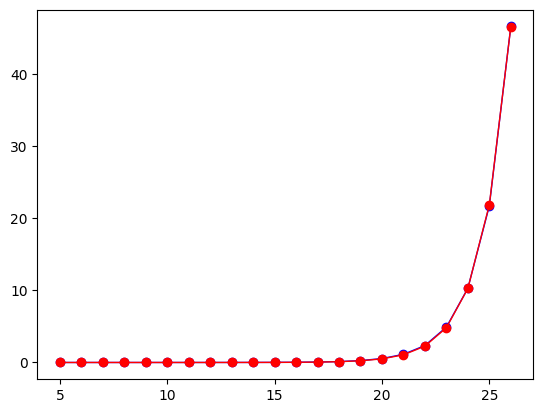

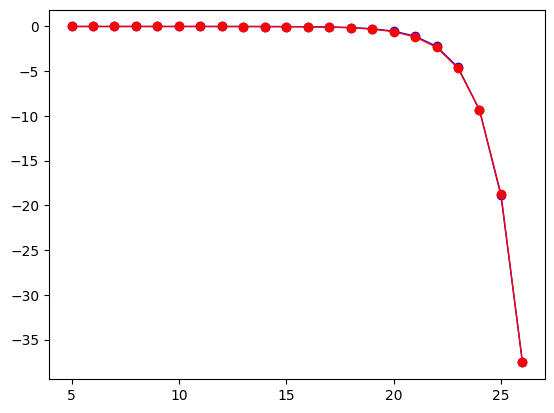

In [71]:
_ = plt.plot(fit_times,fit_data,'-o',label='data',color='blue',linewidth=1)
_ = plt.plot(fit_times,fit_result,'-o',label='fit',color='red',linewidth=1)
#plt.yscale('log')
print(f"chi2: {chi2(fit_result,fit_data,fp_std[cut:-cut])}")

_ = plt.figure()
_ = plt.plot(fit_times,fit_data_tilda,'-o',label='data',color='blue',linewidth=1)
_ = plt.plot(fit_times,fit_result_tilda,'-o',label='fit',color='red',linewidth=1)
#plt.yscale('log')
print(f"chi2: {chi2(fit_result,fit_data,fp_std[cut:-cut])}")

calcolo di elementi di matrice di operatori a quattro fermioni per il calcolo della violazione indiretta di CP nel sistema $K^0-\bar K^0$.



computation of matrix elements of four fermion operators involved in the indirect CP violation in the $K^0-\bar K^0$ system

$K^0-\bar K^0$ matrix element of four fermion operators